# Bike Sharing Prediction

![title](images/bikes.png)

## 1. Context and objective


This notebook is our final project for the class [MAP546P - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast the use of the city bikeshare system** in Washington. It is part of a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand#description).

In [147]:
# Removing FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing libraries
import pandas as pd
import numpy as np
import datetime
from math import cos, pi
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xg

# Importing datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Merging datasets
train["is_train"] = [1 for x in range(train.shape[0])]
test["is_train"] = [0 for x in range(test.shape[0])]
datasets = pd.concat([train, test], sort=False)
datasets = datasets.reset_index(drop = True)

## 2. Exploring the datasets (EDA)
### A. TL;DR

### B. Structure of the datasets

In [53]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,1.0
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.0
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,1.0
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,1.0
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.0
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.0


The **training** dataset has **~11k rows**, and **12 columns**:
- **<font color='grey'>datetime</font>** - hourly date + timestamp (from 2011-01-01 to 2012-12-19)
- **<font color='grey'>season</font>**
    -  1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- **<font color='grey'>holiday</font>** - whether the day is considered a holiday
- **<font color='grey'>workingday</font>** - whether the day is neither a weekend nor holiday
- **<font color='grey'>weather</font>** 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **<font color='grey'>temp</font>** - temperature in Celsius (from 0.82 to 40)
- **<font color='grey'>atemp</font>** - "feels like" temperature in Celsius (from 0.76 to 45.45)
- **<font color='grey'>humidity</font>** - relative humidity (from 0% to 100%)
- **<font color='grey'>windspeed</font>** - wind speed (from 0 to 57)
- **<font color='grey'>casual</font>** - number of non-registered user rentals initiated (from 0 to 367)
- **<font color='grey'>registered</font>** - number of registered user rentals initiated (from 0 to 886)
- **<font color='grey'>count</font>** - number of total rentals (from 1 to 977)

In [54]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,is_train
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.0
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,0.0
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.0
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,0.0
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,0.0
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,0.0
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,0.0
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,0.0


The **test** dataset has **~6k** rows, and **the same columns**.

In [55]:
pd.DataFrame(data=datasets.isna().sum(), columns=["Number of NAs"]).transpose()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
Number of NAs,0,0,0,0,0,0,0,0,0,6493,6493,6493,0


Neither the training nor the test dataset has **missing entries**.

### B. Adding new variables

In [56]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1


We can create new variables from ```datetime```.

In [110]:
# From datetime (for visualizations)
datasets["year"] = [int(datasets.datetime[x][0:4]) for x in range(datasets.shape[0])]
datasets["month"] = [int(datasets.datetime[x][5:7]) for x in range(datasets.shape[0])]
datasets["day"] = [int(datasets.datetime[x][8:10]) for x in range(datasets.shape[0])]
datasets["hour"] = [int(datasets.datetime[x][11:13]) for x in range(datasets.shape[0])]
datasets["weekday"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d').weekday() for x in range(datasets.shape[0])]
datasets["date"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d') for x in range(datasets.shape[0])]
datasets["dayoverall"] = [(datasets.date[x].date() - datetime.date(2011,1,1)).days for x in range(datasets.shape[0])]
datasets["weeknumber"] = [datasets.date[x].isocalendar()[1] for x in range(datasets.shape[0])]
datasets["monthyear"] = datasets.date.dt.to_period('M')

# From other variables (for predictions)
datasets["tempminusatemp"] = [-1 if (datasets.atemp[x] - datasets.temp[x]) < 0
                              else 1 if (datasets.atemp[x] - datasets.temp[x]) > 3.7
                              else float('nan') for x in range(datasets.shape[0])]
datasets["tempcategory"] = [0 if datasets.temp[x] < 13.5
                            else 1 if datasets.temp[x] < 20
                            else 2 if datasets.temp[x] < 27
                            else 3 for x in range(datasets.shape[0])]
datasets["atempcategory"] = [0 if datasets.atemp[x] < 16
                             else 1 if datasets.atemp[x] < 31
                             else 2 for x in range(datasets.shape[0])]
datasets["humiditycategory"] = [0 if datasets.humidity[x] < 47
                                else 1 if datasets.humidity[x] < 78
                                else 2 for x in range(datasets.shape[0])]

In [111]:
train = datasets[datasets.is_train == 1]
test = datasets[datasets.is_train == 0]

**Do we want to keep these new variables?**

Let's check if they explain ```count```, ```casual``` and ```registered```.

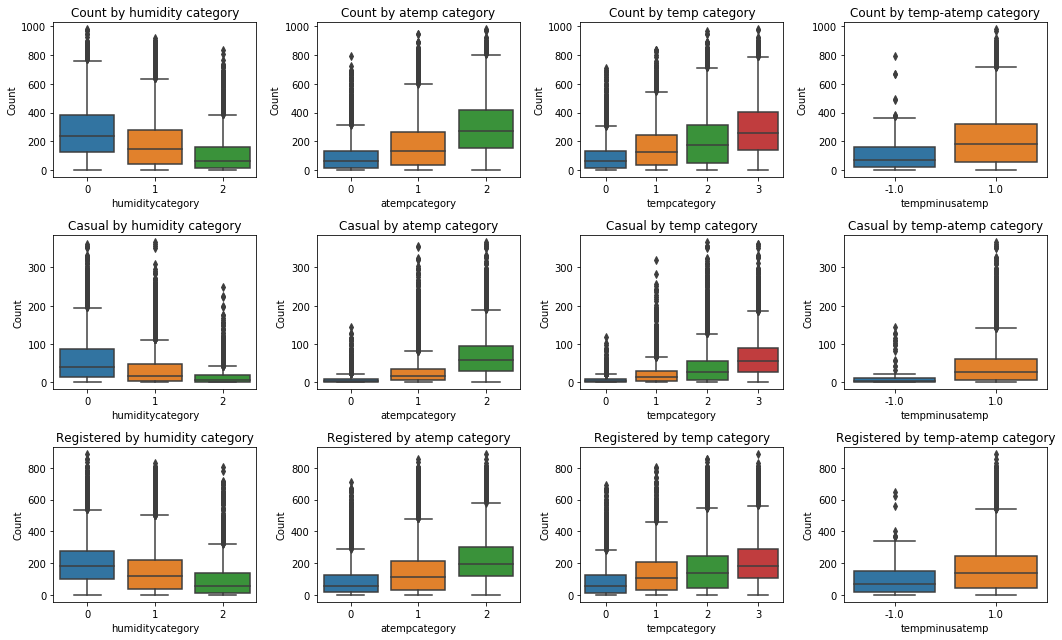

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 9)

# For count
sn.boxplot(data=train, y="count", x="humiditycategory", orient="v", ax=axes[0][0])
axes[0][0].set(ylabel='Count', title="Count by humidity category")

sn.boxplot(data=train, y="count", x="atempcategory", orient="v", ax=axes[0][1])
axes[0][1].set(ylabel='Count', title="Count by atemp category")

sn.boxplot(data=train, y="count", x="tempcategory", orient="v", ax=axes[0][2])
axes[0][2].set(ylabel='Count', title="Count by temp category")

sn.boxplot(data=train, y="count", x="tempminusatemp", orient="v", ax=axes[0][3])
axes[0][3].set(ylabel='Count', title="Count by temp-atemp category")


# For casual
sn.boxplot(data=train, y="casual", x="humiditycategory", orient="v", ax=axes[1][0])
axes[1][0].set(ylabel='Count', title="Casual by humidity category")

sn.boxplot(data=train, y="casual", x="atempcategory", orient="v", ax=axes[1][1])
axes[1][1].set(ylabel='Count', title="Casual by atemp category")

sn.boxplot(data=train, y="casual", x="tempcategory", orient="v", ax=axes[1][2])
axes[1][2].set(ylabel='Count', title="Casual by temp category")

sn.boxplot(data=train, y="casual", x="tempminusatemp", orient="v", ax=axes[1][3])
axes[1][3].set(ylabel='Count', title="Casual by temp-atemp category")


# For casual
sn.boxplot(data=train, y="registered", x="humiditycategory", orient="v", ax=axes[2][0])
axes[2][0].set(ylabel='Count', title="Registered by humidity category")

sn.boxplot(data=train, y="registered", x="atempcategory", orient="v", ax=axes[2][1])
axes[2][1].set(ylabel='Count', title="Registered by atemp category")

sn.boxplot(data=train, y="registered", x="tempcategory", orient="v", ax=axes[2][2])
axes[2][2].set(ylabel='Count', title="Registered by temp category")

sn.boxplot(data=train, y="registered", x="tempminusatemp", orient="v", ax=axes[2][3])
axes[2][3].set(ylabel='Count', title="Registered by temp-atemp category")


plt.tight_layout()

We can observe that the means of the variables ```count```, ```casual``` and ```registered``` differ based on the new variables -> yes, they explain them.

### C. Visualisation
#### Outliers analysis

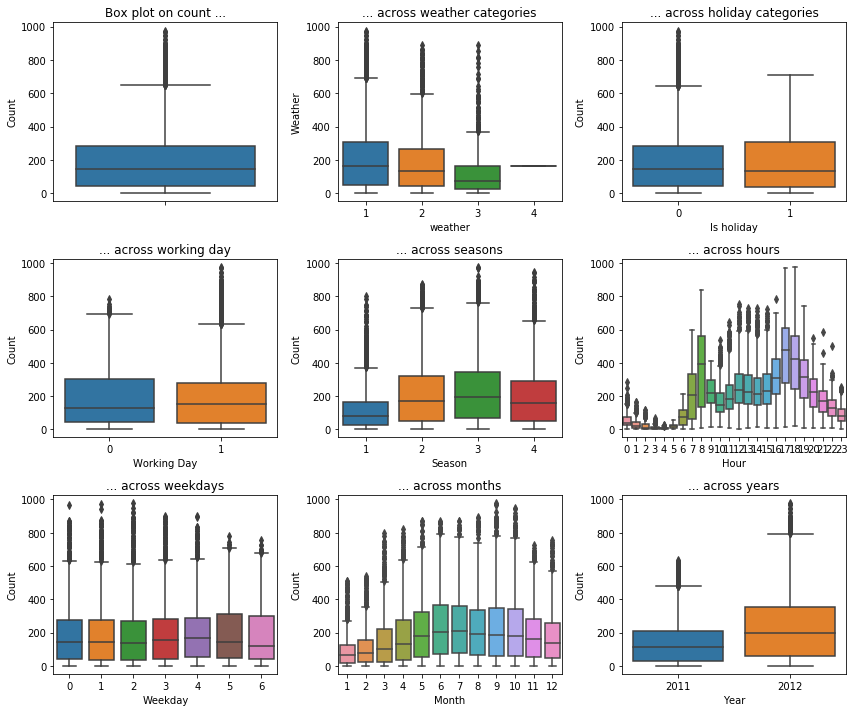

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(12, 10)


# Are there outliers?
sn.boxplot(data=train, y="count", orient="v", ax=axes[0][0])
axes[0][0].set(ylabel='Count', title="Box plot on count ...")


# Who are these outliers? 
sn.boxplot(data=train, y="count", x="weather", orient="v", ax=axes[0][1])
axes[0][1].set(ylabel='Weather', title="... across weather categories")

sn.boxplot(data=train, y="count", x="holiday", orient="v", ax=axes[0][2])
axes[0][2].set(xlabel='Is holiday', ylabel='Count', title="... across holiday categories")

sn.boxplot(data=train,  y="count", x="workingday" ,orient="v", ax=axes[1][0])
axes[1][0].set(xlabel='Working Day', ylabel='Count', title="... across working day")

sn.boxplot(data=train, y="count", x="season", orient="v",ax=axes[1][1])
axes[1][1].set(xlabel='Season', ylabel='Count', title="... across seasons")

sn.boxplot(data=train, y="count", x="hour", orient="v", ax=axes[1][2])
axes[1][2].set(xlabel='Hour', ylabel='Count', title="... across hours")

sn.boxplot(data=train, y="count", x="weekday", orient="v", ax=axes[2][0])
axes[2][0].set(xlabel='Weekday', ylabel='Count', title="... across weekdays")

sn.boxplot(data=train, y="count", x="month", orient="v", ax=axes[2][1])
axes[2][1].set(xlabel='Month', ylabel='Count', title="... across months")

sn.boxplot(data=train,y="count",x="year",orient="v",ax=axes[2][2])
axes[2][2].set(xlabel='Year', ylabel='Count',title="... across years")

plt.tight_layout()

**One can observe (high) outliers in the distribution of the ```count``` variable** (1st plot). They skew its distribution towards right.

The other plots help us investigating these outliers:
- They happen on the days when people work (that is, not during the week-ends nor the holidays)
- But not at the hours when they commute (that is, not from 6am to 9am nor from 4pm to 6pm) 

This indicates that these bikes are primarily used for work commute.

It is also interesting to notice that outliers are independent from the weather, the seasons or the months.

<br>
<br>
<font color='red'>**Remarques précédentes :**

The "count" variable contains outliers that skew the distribution towards right. We will try to investigate why it is so. --> could be linked to outliers of the "humidity" variable ? Few cases when 0 humidity --> high bike demand
General remarks to organize later:
- Few type 4 weather --> probably because it is 0 in this case (very bad weather) --> the average seems weird for this category
- Few spring data points
- Most of the outliers are from "Working Days".

Remplacer le graph température par le graph "heure", beaucoup plus intéressant.</font>

In [61]:
#Let's remove the outliers
trainWithoutOutliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 
print("Number of outliers removed:", train.shape[0] - trainWithoutOutliers.shape[0])

Number of outliers removed: 147


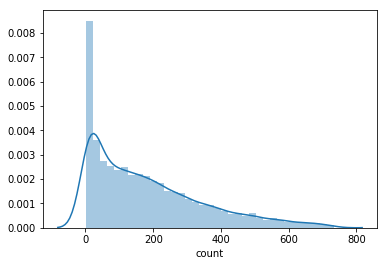

In [62]:
sn.distplot(trainWithoutOutliers['count'])
plt.show()

The distribution is indeed skewed, as seen in the outlier analysis (log scale in the model?)

#### Correlation analysis

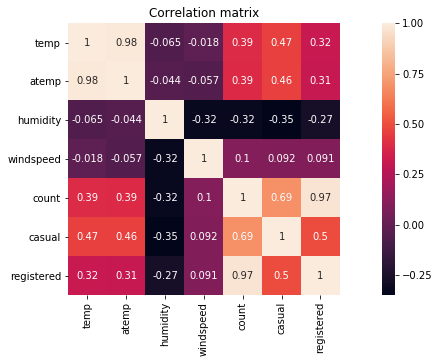

In [63]:
corrMatrix = train[["temp","atemp","humidity","windspeed","count", "casual", "registered"]].corr()

fig,ax = plt.subplots(figsize=(15,5))
sn.heatmap(corrMatrix, square=True,annot=True)
plt.title("Correlation matrix")
plt.show()

- temp and atemp too correlated --> we only keep one: atemp because we want to avoid multicollinearity in a regression
- the variables referring to weather are more related with casual than with registered
- windspeed seems to have a very low correlation with count
- humidity is negatively correlated with the count while temperature is positively correlated with the count (makes sense)

/!\ Serait intéressant de regarder la corrélation weeday - working day - holiday aussi !

**Visualizing count vs the date variables**

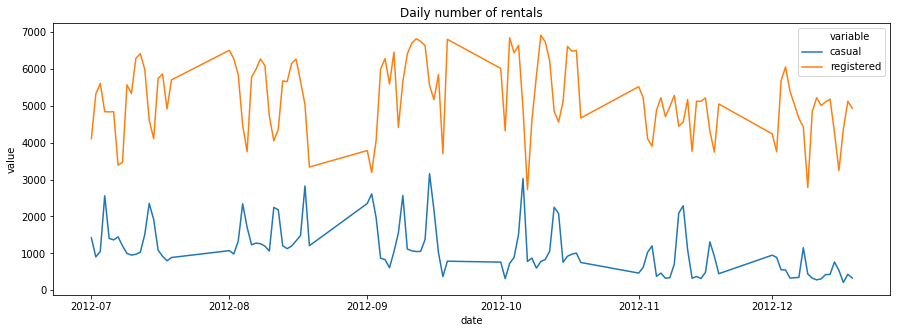

In [64]:
# Aggregating values daily
aggregationDate = train[train.date >= datetime.date(2012,7,1)].groupby("date")["casual", "registered"].sum().reset_index().melt(id_vars=["date"])

# Displaying values
fig, axes= plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sn.lineplot(data=aggregationDate, x="date", y="value", hue="variable", hue_order=["casual", "registered"])
plt.title("Daily number of rentals")
plt.show()

One can observe:
- An overall increase in the number of rentals from 2011 to 2012
- Cyclicity in the two patterns (both at the year level - with an increase over the 1st semester and a decrease over the 2nd semester - and at the weekly level)
- Differences between casual and registered: the growth is not as strong for casual as it is for registered, the spikes do not always coincide

-> Strong indication that we should build two models, one predicting the number of casual users, and one predicting the number of registered users.

<br>

As it is not very easy to identify precisely the patterns, let's take two more aggregated looks:

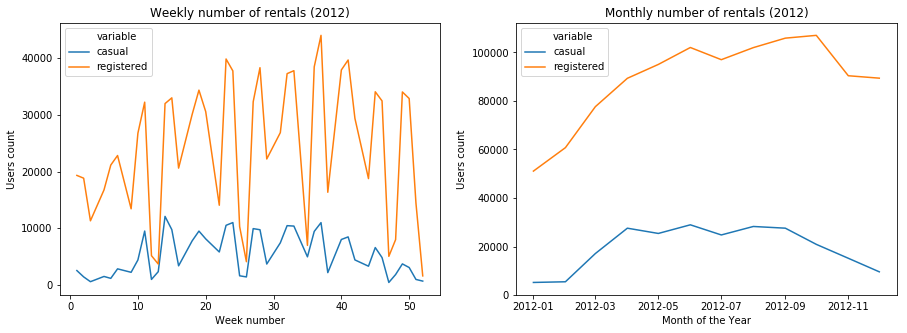

In [65]:
# Aggregating values weekly and monthly
aggregationWeek = train[train.year==2012].groupby("weeknumber")["casual", "registered"].sum().reset_index().melt(id_vars=["weeknumber"])
aggregationMonth = train[train.year==2012].groupby("monthyear")["casual", "registered"].sum().reset_index().melt(id_vars=["monthyear"])
aggregationMonth.monthyear = [aggregationMonth.monthyear[x].to_timestamp() for x in range(aggregationMonth.shape[0])]

# Displaying values
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sn.lineplot(data=aggregationWeek, x="weeknumber", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[0])
axes[0].set(xlabel='Week number', ylabel='Users count',title="Weekly number of rentals (2012)")

sn.lineplot(data=aggregationMonth, x="monthyear", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[1])
axes[1].set(xlabel='Month of the Year', ylabel='Users count',title="Monthly number of rentals (2012)")

plt.show()

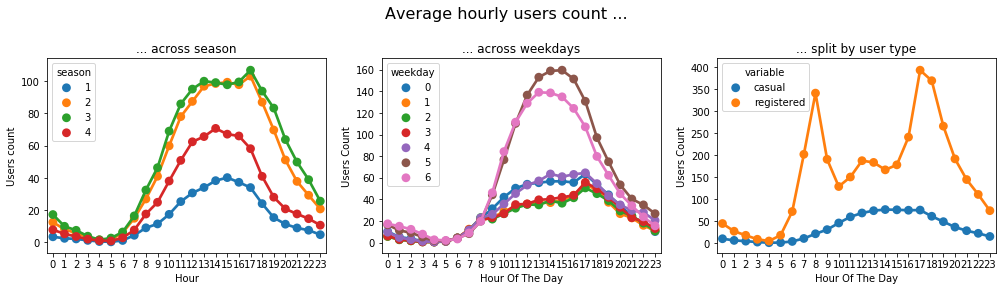

In [66]:
# Displaying the number of rentals for the other date variables
fig, ax= plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(17,4)
fig.suptitle('Average hourly users count ...', fontsize=16)

hourAggregated = pd.DataFrame(train.groupby(["hour","season"],sort=True)["casual"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["casual"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax[0])
ax[0].set(xlabel='Hour', ylabel='Users count',title="... across season", label='big')

hourAggregated = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["casual"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["casual"],hue=hourAggregated["weekday"], data=hourAggregated, join=True,ax=ax[1])
ax[1].set(xlabel='Hour Of The Day', ylabel='Users Count',title="... across weekdays",label='big')

hourTransformed = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax[2])
ax[2].set(xlabel='Hour Of The Day', ylabel='Users Count',title="... split by user type",label='big')

fig.subplots_adjust(top=0.8)


Takeaways:
- The shapes of the cycles vary with the season (the bell is flatter in spring (season = 1)) and the weekday (the bell is sharper on week-ends).
- Again, we observe a completely different pattern for casual vs registered users. The last plot also shows that registered users are mostly people using the bikes for commuting.

<font color='red'>Improvement: replace numbers in the legend labels by words</font>

## Prediction

### A. Preparing the training dataset

During the explanatory data analysis, we draw conclusions on the dataset:
- We should remove outliers
- We should log-transform the response variable
- We should drop some features: ```datetime```, ```day```, ```temp```(???) and ```windspeed``` (???)

Let's thus first implement these changes.

In [114]:
# Merging the datasets
datasetsFinal = pd.concat([train, test], sort=False)

# Removing features
droppingFeatures = ["date", "datetime", "humidity", "windspeed", "dayoverall", "weeknumber", "weekday", "monthyear", "atempcategory", "temp", "atemp"]
datasetsFinal = datasetsFinal.drop(droppingFeatures, axis = 1)
datasetsFinal.head()

,season,holiday,workingday,weather,casual,registered,count,is_train,year,month,hour,tempminusatemp,tempcategory,humiditycategory,day
0,1,0,0,1,3.0,13.0,16.0,1,2011,1,0,1.0,0,2,1
1,1,0,0,1,8.0,32.0,40.0,1,2011,1,1,1.0,0,2,1
2,1,0,0,1,5.0,27.0,32.0,1,2011,1,2,1.0,0,2,1
3,1,0,0,1,3.0,10.0,13.0,1,2011,1,3,1.0,0,1,1
4,1,0,0,1,0.0,1.0,1.0,1,2011,1,4,1.0,0,1,1


In [115]:
# Getting dummies
categoricalFeatures = ["season", "holiday", "workingday", "weather", "tempminusatemp", 
                       "tempcategory", "humiditycategory"]
datasetsFinal = pd.get_dummies(datasetsFinal, columns = categoricalFeatures)


# Splitting training and test sets
trainFinal = datasetsFinal[datasetsFinal.is_train == 1].drop(columns="is_train")
testFinal = datasetsFinal[datasetsFinal.is_train == 0].drop(columns="is_train")

trainFinal.head()

,casual,registered,count,year,month,hour,day,season_1,season_2,season_3,...,weather_4,tempminusatemp_-1.0,tempminusatemp_1.0,tempcategory_0,tempcategory_1,tempcategory_2,tempcategory_3,humiditycategory_0,humiditycategory_1,humiditycategory_2
0,3.0,13.0,16.0,2011,1,0,1,1,0,0,...,0,0,1,1,0,0,0,0,0,1
1,8.0,32.0,40.0,2011,1,1,1,1,0,0,...,0,0,1,1,0,0,0,0,0,1
2,5.0,27.0,32.0,2011,1,2,1,1,0,0,...,0,0,1,1,0,0,0,0,0,1
3,3.0,10.0,13.0,2011,1,3,1,1,0,0,...,0,0,1,1,0,0,0,0,1,0
4,0.0,1.0,1.0,2011,1,4,1,1,0,0,...,0,0,1,1,0,0,0,0,1,0


We now have 25 response variables.

Should we consider ```year```, ```month```, ```day```, ```hour```, as categorical variables?

### B. Building the model

We are going to adopt three distinct strategies to predict the number of rentals:
1. Predicting the variable ```count```
2. Predicting the variables ```casual``` and ```registered``` with the same model and summing them up
3. Predicting the variables ```casual``` and ```registered``` with a distinct model for each and summing them up

For each one of these strategies, we will compare several ML algorithms: ```LinearRegression```,```RandomForestRegressor```,```AdaBoostRegressor```,```BaggingRegressor```,```SVR```,```KNeighborsRegressor```. 

For comparing the performances of the models and of the strategies, we will compute and use their ```RMSLE```.

#### 1. Predicting ```count```

In [116]:
# Separating into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(trainFinal.drop(['count', 'registered', 'casual'],axis=1),
                                                    trainFinal['count'],
                                                    test_size=0.20,
                                                    random_state=42)

In [119]:
# Listing the models we will try
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
modelLinear= LinearRegression()
model_names = ['LinearRegression','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
rmsleStrat1 = []

# Log-transforming the response variable
y_trainLog = np.log1p(y_train)

# Fitting the linear regression separately
modelLinear.fit(x_train, y_trainLog)
predLinear = modelLinear.predict(x_test)
rmsleStrat1.append(np.sqrt(mean_squared_log_error(np.expm1(predLinear), y_test)))

for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train, y_trainLog)
    pred = clf.predict(x_test)
    rmsleStrat1.append(np.sqrt(mean_squared_log_error(np.expm1(pred), y_test)))


In [120]:
# Displaying the results of this strategy
strat1 = pd.DataFrame({'Modelling Algo': model_names,'RMSLE': [round(x,3) for x in rmsleStrat1]}).sort_values(by=["Modelling Algo"])
strat1["Rank"] = strat1["RMSLE"].rank().astype(int)
strat1

,Modelling Algo,RMSLE,Rank
2,AdaBoostRegressor,0.682,6
3,BaggingRegressor,0.349,2
5,KNeighborsRegressor,0.482,5
0,LinearRegression,1.023,7
1,RandomForestRegressor,0.344,1
6,Ridge,1.023,7
4,SVR,0.398,4
7,XGBRegressor,0.384,3


#### 2. Predicting ```registered``` and ```casual``` with the same model

In [121]:
# Separating into training and testing set
x_train_separate, x_test_separate, y_train_casual, y_test_casual = train_test_split(trainFinal.drop(['count', 'registered', 'casual'], axis=1),
                                                                                    trainFinal['casual'],
                                                                                    test_size=0.20,
                                                                                    random_state=42)

x_train_separate, x_test_separate, y_train_registered, y_test_registered = train_test_split(trainFinal.drop(['count', 'registered', 'casual'], axis=1),
                                                                                            trainFinal['registered'],
                                                                                            test_size=0.20,
                                                                                            random_state=42)

In [122]:
# Listing the models we will try
models_separate=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
model_names_separate=['LinearRegression','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
modelLinear = LinearRegression()
rmsleCountStrat2 = []
rmsleCasualStrat2 = []
rmsleRegisteredStrat2 = []


# Log transforming the response variables
y_train_casualLog = np.log1p(y_train_casual)
y_train_registeredLog = np.log1p(y_train_registered)


# Fitting the linear regressions separately
# 1. For casual
modelLinear.fit(X = x_train_separate,y = y_train_casualLog)
predLinearCasual = modelLinear.predict(x_test_separate)
# Correcting the negative counts(should be null)
predLinearCasual = [0 if predLinearCasual[x] < 0 else predLinearCasual[x] for x in range(len(predLinearCasual))]
rmsleCasualStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearCasual), y_test_casual)))

# 2. For registered
modelLinear.fit(X = x_train_separate,y = y_train_registeredLog)
predLinearRegistered = modelLinear.predict(x_test_separate)
# Correcting the negative counts(should be null)
predLinearRegistered = [0 if predLinearRegistered[x] < 0 else predLinearRegistered[x] for x in range(len(predLinearRegistered))]
rmsleRegisteredStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearRegistered), y_test_registered)))

# 3. For their sum
rmsleCountStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearCasual) + np.expm1(predLinearRegistered),
                                                       y_test_casual + y_test_registered)))


# Fitting the other models
for model in range(len(models_separate)):
    clf = models_separate[model]
    # 1. For casual
    clf.fit(x_train_separate, y_train_casualLog)
    predCasual = clf.predict(x_test_separate)
    predCasual = [0 if predCasual[x] < 0 else predCasual[x] for x in range(len(predCasual))]
    rmsleCasualStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual), y_test_casual)))
    # 2. For registered
    clf.fit(x_train_separate, y_train_registeredLog)
    predRegistered = clf.predict(x_test_separate)
    predRegistered = [0 if predRegistered[x] < 0 else predRegistered[x] for x in range(len(predRegistered))]
    rmsleRegisteredStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predRegistered), y_test_registered)))
    # 3. For their sum
    rmsleCountStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual) + np.expm1(predRegistered),
                                                           y_test_casual + y_test_registered)))

In [124]:
strat2 = pd.DataFrame({'Modelling Algo': model_names_separate,
                       'RMSLE - Registered': [round(x,3) for x in rmsleRegisteredStrat2],
                       'RMSLE - Casual': [round(x,3) for x in rmsleCasualStrat2],
                       'RMSLE - Count': [round(x,3) for x in rmsleCountStrat2]}).sort_values(by=["Modelling Algo"])
strat2["Rank (by registered)"] = strat2["RMSLE - Registered"].rank().astype(int)
strat2["Rank (by casual)"] = strat2["RMSLE - Casual"].rank().astype(int)
strat2["Rank (by count)"] = strat2["RMSLE - Count"].rank().astype(int)
strat2

,Modelling Algo,RMSLE - Registered,RMSLE - Casual,RMSLE - Count,Rank (by registered),Rank (by casual),Rank (by count)
2,AdaBoostRegressor,0.661,0.774,0.660,6,6,6
3,BaggingRegressor,0.340,0.537,0.334,2,3,2
5,KNeighborsRegressor,0.487,0.580,0.481,5,5,5
0,LinearRegression,1.030,0.941,1.021,7,7,7
1,RandomForestRegressor,0.338,0.534,0.332,1,2,1
6,Ridge,1.030,0.941,1.021,7,7,7
4,SVR,0.398,0.526,0.392,4,1,4
7,XGBRegressor,0.380,0.550,0.377,3,4,3


#### 3. Predicting ```registered``` and ```casual``` with distinct models

In [128]:
# Listing the models we will try
models_separate=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
model_names_separate=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
modelsCasual = []
modelsRegistered = []
rmsleCountStrat3 = []
rmsleCasualStrat3 = []
rmsleRegisteredStrat3 = []


# Log transforming the response variables
y_train_casualLog = np.log1p(y_train_casual)
y_train_registeredLog = np.log1p(y_train_registered)


# Fitting the other models
for modelCasual in range(len(models_separate)):
    for modelRegistered in range(len(models_separate)):
        # 1. For casual
        clfCasual = models_separate[modelCasual]
        modelsCasual.append(model_names_separate[modelCasual])
        clfCasual.fit(x_train_separate, y_train_casualLog)
        predCasual = clfCasual.predict(x_test_separate)
        predCasual = [0 if predCasual[x] < 0 else predCasual[x] for x in range(len(predCasual))]
        rmsleCasualStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual), y_test_casual)))
        # 2. For registered
        clfRegistered = models_separate[modelRegistered]
        modelsRegistered.append(model_names_separate[modelRegistered])
        clfRegistered.fit(x_train_separate, y_train_registeredLog)
        predRegistered = clfRegistered.predict(x_test_separate)
        predRegistered = [0 if predRegistered[x] < 0 else predRegistered[x] for x in range(len(predRegistered))]
        rmsleRegisteredStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predRegistered), y_test_registered)))
        # 3. For their sum
        rmsleCountStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual) + np.expm1(predRegistered),
                                                       y_test_casual + y_test_registered)))

In [135]:
strat3 = pd.DataFrame({'Model - Casual': modelsCasual,
                       'Model - Registered': modelsRegistered,
                       'RMSLE - Casual': [round(x,3) for x in rmsleCasualStrat3],
                       'RMSLE - Registered': [round(x,3) for x in rmsleRegisteredStrat3],
                       'RMSLE - Count': [round(x,3) for x in rmsleCountStrat3]}).sort_values(by=["Model - Casual"])
strat3["Rank (by casual)"] = strat3["RMSLE - Casual"].rank().astype(int)
strat3["Rank (by registered)"] = strat3["RMSLE - Registered"].rank().astype(int)
strat3["Rank (by count)"] = strat3["RMSLE - Count"].rank().astype(int)
strat3.sort_values("Rank (by count)")


,Model - Casual,Model - Registered,RMSLE - Casual,RMSLE - Registered,RMSLE - Count,Rank (by casual),Rank (by registered),Rank (by count)
23,SVR,BaggingRegressor,0.526,0.339,0.331,4,2,1
21,SVR,RandomForestRegressor,0.526,0.342,0.333,4,5,2
14,BaggingRegressor,RandomForestRegressor,0.538,0.342,0.335,19,5,4
2,RandomForestRegressor,BaggingRegressor,0.535,0.345,0.335,14,10,4
30,KNeighborsRegressor,BaggingRegressor,0.580,0.339,0.335,32,2,4
42,XGBRegressor,RandomForestRegressor,0.550,0.340,0.336,25,4,6
0,RandomForestRegressor,RandomForestRegressor,0.534,0.348,0.338,11,13,7
44,XGBRegressor,BaggingRegressor,0.550,0.344,0.339,25,8,9
16,BaggingRegressor,BaggingRegressor,0.534,0.346,0.339,11,12,9
28,KNeighborsRegressor,RandomForestRegressor,0.580,0.344,0.339,32,8,9


Conclusion: minimizing the MSE for each one of the models seems to be the best strategy.

#### 4. Hyper tuning
Now that we have identified that the best models are **random forest** and **xgboost** for ```Registered```, and **SVR** for ``Casual``, we can focus on these models. So far, we have built models using default parameters. But we sure can improve the scores by hyper tuning each of their parameters.

We also want to select the best subset of variables for these models. Do not forget that this needs to be done for each variable (```registered``` and ```casual``` separately).

<br>

**Random Forest for ```Registered```**

First, we are performing a random search for narrowing down the range for each hyperparameter.

In [143]:
# Defining the list of parameters to test
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

 # Creating the random grid
random_grid_rf = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

# Using the random grid to search for best hyperparameters
rf_registered = RandomForestRegressor()
rf_random_registered = RandomizedSearchCV(estimator = rf_registered, param_distributions = random_grid_rf, 
                                          n_iter = 5, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random_registered.fit(x_train_separate, y_train_registeredLog)



Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try with GridSearchCV.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search_rf_registered = GridSearchCV(estimator = rf_registered, param_grid = param_grid_rf, 
                                         cv = 3, n_jobs = -1, verbose = 2)

In [146]:
print("Best parameters: ", rf_random_registered.best_params_)

# Predicting with the best model on the test set
best_rf = rf_random_registered.best_estimator_
predictions_rf = best_rf.predict(x_test_separate)

# Computing the results
print("RMSLE: ", np.sqrt(mean_squared_log_error(np.expm1(predictions_rf), y_test_registered)))
# Average RMSLE for Registered with RF: 0.340 to 0.352

Best parameters:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
RMSLE:  0.38891982048080725


**XGboost for ```Registered```**

**SVR for ```Casual```**


# Graveyard